# Forest Cover Type Classification

This notebook demonstrates how to predict forest cover types using cartographic and environmental features from the Covertype dataset. We will:
- Load and explore the data
- Preprocess features
- Train and evaluate multi-class classifiers (Random Forest and XGBoost)
- Visualize confusion matrices
- Analyse feature importance
- Perform hyperparameter tuning


## Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import scipy.stats as stats

sns.set_style("whitegrid")


##  Load and Inspect the Data

We will load the `covertype.csv` dataset and take a quick look at its structure and target distribution.


In [2]:
# Load dataset
df = pd.read_csv("covertype.csv")

# Display first 5 rows
df.head()


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
# Check dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Unnamed: 0                          581012 non-null  int64
 1   Unnamed: 1                          581012 non-null  int64
 2   Unnamed: 2                          581012 non-null  int64
 3   Elevation                           581012 non-null  int64
 4   Aspect                              581012 non-null  int64
 5   Slope                               581012 non-null  int64
 6   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 7   Vertical_Distance_To_Hydrology      581012 non-null  int64
 8   Horizontal_Distance_To_Roadways     581012 non-null  int64
 9   Hillshade_9am                       581012 non-null  int64
 10  Hillshade_Noon                      581012 non-null  int64
 11  Hillshade_3pm                       581012 non-null 

In [4]:
# Target distribution
df['Cover_Type'].value_counts()


Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

## Prepare Features and Target

We will separate features (`X`) and target (`y`).  
Categorical features are already one-hot encoded, so no extra preprocessing is needed.


In [5]:
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']


##  Train-Test Split

We split the data into training and test sets. Stratification ensures the class distribution is preserved.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


##  Train Models

We will train two tree-based models:
1. Random Forest
2. XGBoost


In [7]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [9]:
# Shift target for XGBoost (0-indexed)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train_xgb)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
# Shift predictions back to original labels
y_pred_xgb += 1


##  Evaluate Models

We will check the accuracy and plot the confusion matrix.


In [ ]:

# Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


Random Forest Accuracy: 0.9533316695782381
XGBoost Accuracy: 0.812603805409499


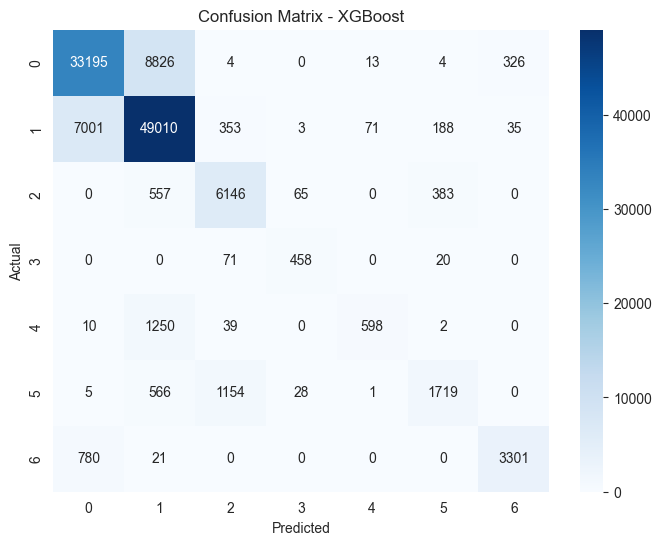

In [ ]:
# Confusion Matrix for XGBoost
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [ ]:
# Classification Report for XGBoost
print("Classification Report - XGBoost: \n")
print(classification_report(y_test, y_pred_xgb))

Classification Report - XGBoost: 

              precision    recall  f1-score   support

           1       0.81      0.78      0.80     42368
           2       0.81      0.86      0.84     56661
           3       0.79      0.86      0.82      7151
           4       0.83      0.83      0.83       549
           5       0.88      0.31      0.46      1899
           6       0.74      0.49      0.59      3473
           7       0.90      0.80      0.85      4102

    accuracy                           0.81    116203
   macro avg       0.82      0.71      0.74    116203
weighted avg       0.81      0.81      0.81    116203



##  Feature Importance

We will visualise the top features contributing to the XGBoost model.


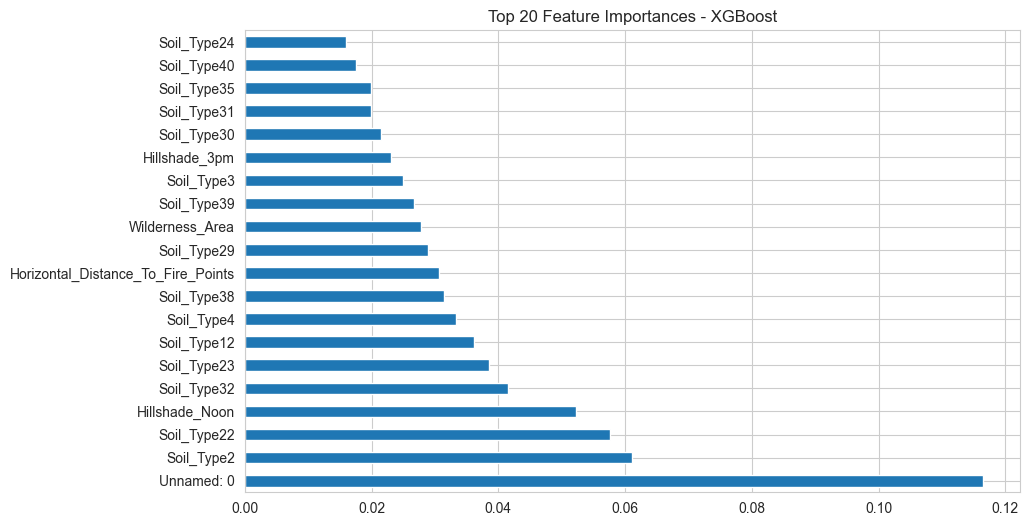

In [ ]:
feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances - XGBoost")
plt.show()


##  Hyperparameter Tuning

We can perform randomized search to optimise XGBoost parameters.


In [ ]:
# Parameter distributions
param_dist = {
    'n_estimators': stats.randint(100, 300),
    'max_depth': stats.randint(4, 10),
    'learning_rate': stats.uniform(0.05, 0.2),
    'subsample': stats.uniform(0.6, 0.4),
    'colsample_bytree': stats.uniform(0.6, 0.4)
}

rand_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # number of random combinations to try
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

rand_search.fit(X_train, y_train_xgb)

print("Best params:", rand_search.best_params_)
print("Best CV score:", rand_search.best_score_)

# Predict using best estimator
y_pred_rand = rand_search.best_estimator_.predict(X_test) + 1


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'colsample_bytree': np.float64(0.9706635463175177), 'learning_rate': np.float64(0.1954543991712842), 'max_depth': 9, 'n_estimators': 289, 'subsample': np.float64(0.7301321323053057)}
Best CV score: 0.9574061602498597


##  Compare Random Forest vs XGBoost

We'll compare the accuracy of the two models using a simple bar chart.


/var/folders/jx/zcfwn8ds7wncqbhz7xcskktw0000gn/T/ipykernel_93750/2136374684.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


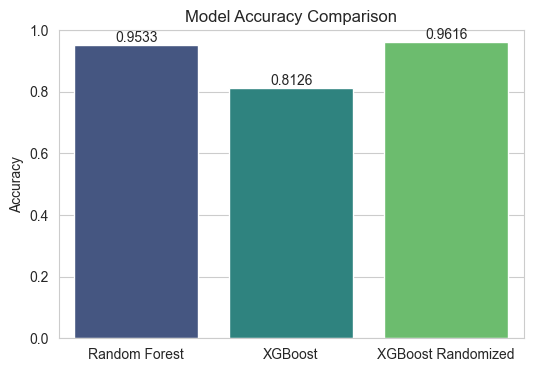

In [ ]:
# Prepare data
model_names = ['Random Forest', 'XGBoost','XGBoost Randomized']
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_rand)
]

# Plot comparison
plt.figure(figsize=(6,4))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.show()


# Summary

- Loaded and explored the Covertype dataset
- Trained Random Forest & XGBoost classifiers
- Evaluated using accuracy, confusion matrices, and classification reports
- Visualised top features for XGBoost
- Performed hyperparameter tuning using RandomizedSearchCV
- Compared models with a bar chart